In this guide, we will show how to generate novel images based on a text prompt using the KerasCV implementation of stability.ai's text-to-image model, Stable Diffusion.

Stable Diffusion is a powerful, open-source text-to-image generation model. While there exist multiple open-source implementations that allow you to easily create images from textual prompts, KerasCV's offers a few distinct advantages. These include XLA compilation and mixed precision support, which together achieve state-of-the-art generation speed.

In this guide, we will explore KerasCV's Stable Diffusion implementation, show how to use these powerful performance boosts, and explore the performance benefits that they offer.

To get started, let's install a few dependencies and sort out some imports:
pip3 install tensorflow keras_cv --upgrade --quiet
pip3 install PILLOW keras_cv pycocotools pyococotools
apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [2]:
import time
import PIL
import tensorflow as tf
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime

2023-02-18 16:38:50.960756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/Users/nathan/workspace/tensor_flow_projects/tensor_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# create a basic naming root for any files that we create and want to save during this session
time_str = datetime.now().strftime("%Y_%m_%d_%H_")
output_name = os.getcwd() + "/output_images/" + time_str
img_num = 0
print(output_name)
# model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

# MQ model for standard operation speed
# model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)
# LQ and fast version of the model
model = keras_cv.models.StableDiffusion(img_width=96, img_height=96, jit_compile=False)
# HQ and slow version
#model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

# simple function to load image
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# simple function to display image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def save_images(images):
    global img_num
    for i in range(len(images)):
        tf.keras.utils.save_img(output_name + str(img_num) + ".png", images[i])
        img_num = img_num + 1

def save_image(image):
    global img_num
    tf.keras.utils.save_img(output_name + str(img_num) + ".png", np.squeeze(image, 0))
    img_num = img_num + 1

def plot_images(images):
    print("images length: ", len(images))
    if len(images) > 1:
        nrows, hop_size = adjustGrid(len(images))
        plt.figure(figsize=(hop_size*10, nrows*10))
        plt.margins(0.0)
        # for each lines of the plo%
        print("plotting {} total images with {} columns in {} rows".format(len(images), hop_size, nrows))
        for i in range(len(images)):
            ax = plt.subplot(nrows, hop_size, i+1)
            plt.imshow(images[i])
            plt.axis("off")
            plt.savefig(output_name + str(img_num) + "_figure.png")
    else:
      plot_image(image)

def plot_image(image):
    image = np.squeeze(image, 0)
    plt.figure(figsize=(20, 20))
    plt.margins(0.0)
    plt.imshow(image)
    plt.axis("off")
    plt.savefig(output_name + str(img_num) + "_figure.png")

def singleImage(source, style):
    output_images = []
    source_image = load_img(source)
    style_image = load_img(style)
    output_images.extend(hub_model(tf.constant(source_image), tf.constant(style_image))[0])
    save_images(output_images)
    output_images.extend(style_image)
    output_images.extend(source_image)
    output_images.reverse()
    plot_images(output_images)

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def adjustGrid(num, cmax=5):
    # find place where we "flip", use that to determine number of rows and columns
    # go from 1 to half of number
    rnum = 1
    cnum = num
    for rn in range(1, ceil(num/2) +1):
        rnum = rn
        cnum = ceil(num/rnum)
        # if the number of columns is no longer greater than the number of rows, undo the change and export numbers
        if cnum <= rnum and cnum <= cmax:
            break
    total = rnum * cnum
    # if total < num:
    # rnum = rnum + 1
    return (rnum, cnum)

/Users/nathan/workspace/tensor_flow_projects/stable_diffusion/output_images/2023_02_18_16_
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


THIS BELOW CELL IS FOR CREATING A SINGLE OUTPUT FILE

16/16 [==============================] - 283s 16s/step


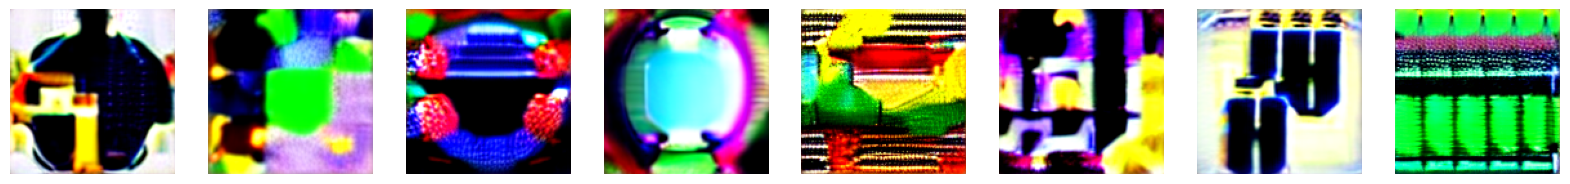

In [7]:
batch = 8
seed = 10
steps = 15
prompt =  "balls to the walls, highly detailed, fantasy, character art, strong woman, extreme, action, photograph"

#########################################################
images = model.text_to_image(
    prompt,
    seed=seed,
    num_steps=steps,
    batch_size=batch,
)
keras.backend.clear_session()  # Clear session to preserve memory

plot_images(images)
img_num = save_images(images, img_num)

In [ ]:
# This pannel is for easily producing several images using different prompts
batch = 1
seed = 2
steps = 5
prompts =  [
    "balls to the walls, cubist, sports, inspirational, walls, balls, fantasy, photograph", 
    "cute and adorable elephants, sureal, salvidore dali, melting"
]

def convertMultiple(prompts, batch=1, seed=None, steps=20):
    # empty out the images list so I dont accidently save stuff from prior runs of the code
    keras.backend.clear_session()  # Clear session to preserve memory
    outputs = []
    for i in range(len(prompts)):
        print("running prompt #",i, " : ", prompts[i])
        t_images = model.text_to_image(
            prompts[i],
            seed=seed,
            num_steps=steps,
            batch_size=batch,
        )
        outputs.extend(t_images)
    return outputs

images = convertMultiple(prompts, batch=batch, seed=seed, steps=steps)
plot_images(images)
img_num = save_images(images, img_num)

In [ ]:
# this cell is for saving each step of the process as it's on image
seed = 0
steps = 4
# how often to output an image
mod = 1
prompt = "phychadelic elephants dancing with umbrellas, elephants on stilts"

def save_each_ittr(prompt, seed=None, steps=20, mod=5):
    outputs = []
    for i in range (1, steps+1, mod):
        keras.backend.clear_session() 
        output = model.text_to_image(
            prompt,
            seed=seed,
            num_steps=i,
            batch_size=1,
        )
        print("created image with prompt {} and iter_num {}".format(prompt, i))
        outputs.extend(output)
    return outputs

images = save_each_ittr(prompt, seed=0, steps=20, mod=5)
plot_images(images)
img_num = save_images(images, img_num)